# Homework 1 - Problem 1 - simulate 3 spheres

## Imports

In [27]:
import numpy as np
import matplotlib.pyplot as plt

fromm IPython.display import clear_output # Only for iPython

import elasticenergies_gradient_and_hessian as EE_calc
# import elasticenergies_gradient_and_hessian

SyntaxError: invalid syntax (1713869101.py, line 4)

## Testing the EE_calc helper functions

In [23]:
EA = 3.1416e+03
deltaL = 0.05
xk = 0.0062
yk = -0.0420
xkp1 = 0.0500
ykp1 = -0.0661
gradEnergy = EE_calc.gradEs(xk, yk, xkp1, ykp1, deltaL, EA)
hessEnergy = EE_calc.hessEs(xk, yk, xkp1, ykp1, deltaL, EA)
print(gradEnergy)
print(hessEnergy)

[ 0.41289914 -0.2271888  -0.41289914  0.2271888 ]
[[ 48228.04714612 -26541.62385891 -48228.04714612  26541.62385891]
 [-26541.62385891  14594.52593277  26541.62385891 -14594.52593277]
 [-48228.04714612  26541.62385891  48228.04714612 -26541.62385891]
 [ 26541.62385891 -14594.52593277 -26541.62385891  14594.52593277]]


## Objective Function

In [15]:
def objfun(q_guess, q_old, u_old, dt, tol, maximum_iter,
           m, mMat,  # inertia
           EI, EA,   # elastic stiffness
           W, C,     # external force
           deltaL,
           free_index): # free_index indicates the DOFs that evolve under equations of motion

    q_new = q_guess.copy()

    # Newton-Raphson scheme
    iter_count = 0  # number of iterations
    error = tol * 10  # norm of function value (initialized to a value higher than tolerance)
    flag = 1  # Start with a 'good' simulation (flag=1 means no error)

    while error > tol:
        # Get elastic forces
        Fb, Jb = EE_calc.getFb(q_new, EI, deltaL)
        Fs, Js = EE_calc.getFs(q_new, EA, deltaL)

        # Viscous force
        Fv = -C @ (q_new - q_old) / dt
        Jv = -C / dt

        # Equation of motion
        f = m * (q_new - q_old) / dt**2 - m * u_old / dt - (Fb + Fs + W + Fv)

        # Manipulate the Jacobians
        J = mMat / dt**2 - (Jb + Js + Jv)

        # We have to separate the "free" parts of f and J
        f_free = f[free_index]
        J_free = J[np.ix_(free_index, free_index)]

        # Newton's update
        # q_new = q_new - np.linalg.solve(J, f)
        # We have to only update the free DOFs
        dq_free = np.linalg.solve(J_free, f_free)
        q_new[free_index] = q_new[free_index] - dq_free

        # Get the norm
        # error = np.linalg.norm(f)
        # We have to calculate the errors based on free DOFs
        error = np.linalg.norm(f_free)

        # Update iteration number
        iter_count += 1
        print(f'Iter={iter_count-1}, error={error:.6e}')

        if iter_count > maximum_iter:
            flag = -1  # return with an error signal
            return q_new, flag

    return q_new, flag

## Main

In [24]:
# import numpy as np

# Inputs (SI units)
# number of vertices
nv = 5 # Odd vs even number should show different behavior
ndof = 2*nv

# Time step
dt = 1e-2

# Rod Length
RodLength = 0.10

# Discrete length
deltaL = RodLength / (nv - 1)

# Radius of spheres
R = np.zeros(nv)  # Vector of size N - Radius of N nodes
R[:] = 0.005 # deltaL / 10: Course note uses deltaL/10
midNode = int((nv + 1) / 2)
R[midNode -1 ] = 0.025

# Densities
rho_metal = 7000
rho_gl = 1000
rho = rho_metal - rho_gl

# Cross-sectional radius of rod
r0 = 1e-3

# Young's modulus
Y = 1e9

# Viscosity
visc = 1000.0

# Maximum number of iterations in Newton Solver
maximum_iter = 100

# Total simulation time (it exits after t=totalTime)
totalTime = 10

# Indicate whether images should be saved
saveImage = 0

# How often the plot should be saved?
plotStep = 50

# Utility quantities
ne = nv - 1
EI = Y * np.pi * r0**4 / 4
EA = Y * np.pi * r0**2

# Tolerance on force function
tol = EI / RodLength**2 * 1e-3  # small enough force that can be neglected

# Geometry of the rod
nodes = np.zeros((nv, 2))
for c in range(nv):
    nodes[c, 0] = c * RodLength / ne

# Compute Mass
m = np.zeros(ndof)
for k in range(nv):
  m[2*k] = 4 / 3 * np.pi * R[k]**3 * rho_metal # Mass for x_k
  m[2*k+1] = m[2*k] # Mass for y_k

mMat = np.diag(m)  # Convert into a diagonal matrix

# Gravity
W = np.zeros(ndof)
g = np.array([0, -9.8])  # m/s^2 - gravity
for k in range(nv):
  W[2*k]   = m[2*k] * g[0] # Weight for x_k
  W[2*k+1] = m[2*k] * g[1] # Weight for y_k

# Viscous damping matrix, C
C = np.zeros((ndof, ndof))
for k in range(nv):
  C[2*k,2*k]   = 6 * np.pi * visc * R[k]
  C[2*k+1, 2*k+1]   = 6 * np.pi * visc * R[k]

# Initial conditions
q0 = np.zeros(ndof)
for c in range(nv):
    q0[2 * c] = nodes[c, 0]
    q0[2 * c + 1] = nodes[c, 1]

q = q0.copy()
u = (q - q0) / dt

In [25]:
all_DOFs = np.arange(ndof)
fixed_index = np.array([0, 1])

# Get the difference of two sets using np.setdiff1d
free_index = np.setdiff1d(all_DOFs, fixed_index)

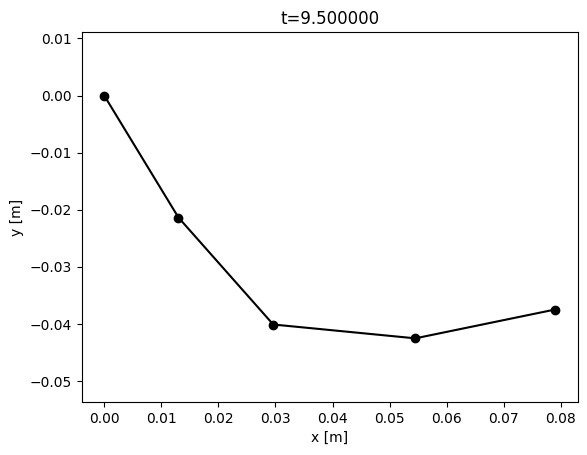

t=9.500000
Iter=0, error=1.555868e+00
Iter=1, error=9.231453e-04
Iter=2, error=1.767769e-10
t=9.510000
Iter=0, error=1.554387e+00
Iter=1, error=9.237686e-04
Iter=2, error=1.771489e-10
t=9.520000
Iter=0, error=1.552906e+00
Iter=1, error=9.243890e-04
Iter=2, error=1.774851e-10
t=9.530000
Iter=0, error=1.551427e+00
Iter=1, error=9.250063e-04
Iter=2, error=1.767819e-10
t=9.540000
Iter=0, error=1.549950e+00
Iter=1, error=9.256206e-04
Iter=2, error=1.772284e-10
t=9.550000
Iter=0, error=1.548474e+00
Iter=1, error=9.262318e-04
Iter=2, error=1.773972e-10
t=9.560000
Iter=0, error=1.547000e+00
Iter=1, error=9.268400e-04
Iter=2, error=1.774823e-10
t=9.570000
Iter=0, error=1.545527e+00
Iter=1, error=9.274452e-04
Iter=2, error=1.771084e-10
t=9.580000
Iter=0, error=1.544055e+00
Iter=1, error=9.280472e-04
Iter=2, error=1.775789e-10
t=9.590000
Iter=0, error=1.542586e+00
Iter=1, error=9.286462e-04
Iter=2, error=1.764167e-10
t=9.600000
Iter=0, error=1.541117e+00
Iter=1, error=9.292422e-04
Iter=2, error=1

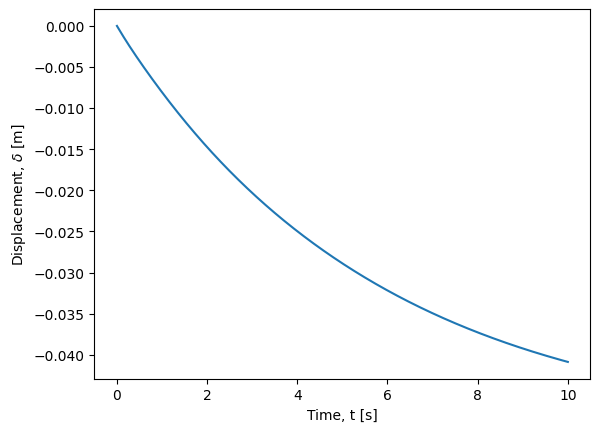

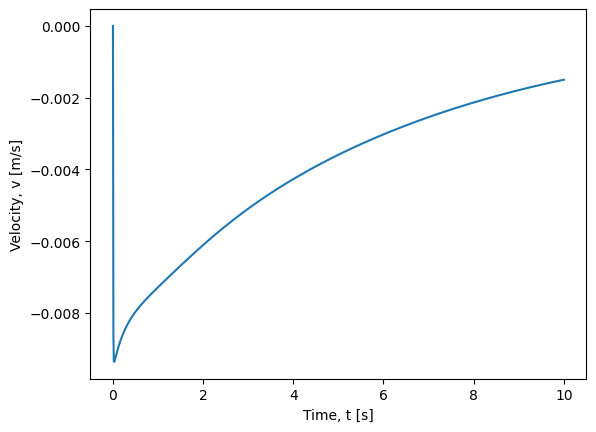

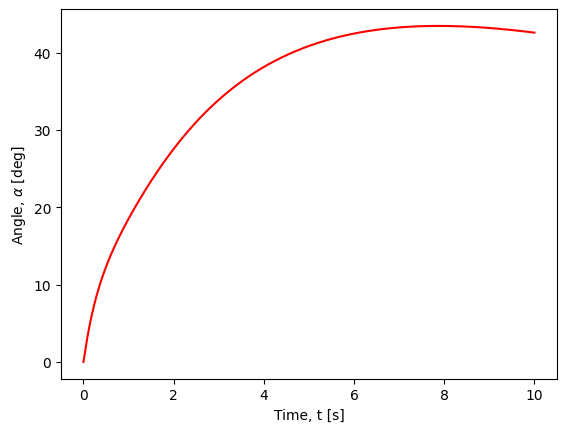

In [26]:
# Number of time steps
Nsteps = round(totalTime / dt)

ctime = 0

all_pos = np.zeros(Nsteps)
all_v = np.zeros(Nsteps)
midAngle = np.zeros(Nsteps)

for timeStep in range(1, Nsteps):  # Python uses 0-based indexing, hence range starts at 1
    print(f't={ctime:.6f}')

    q, error = objfun(q0, q0, u, dt, tol, maximum_iter, m, mMat, EI, EA, W, C, deltaL,
                      free_index) # This line is different from our previous exercise

    if error < 0:
        print('Could not converge. Sorry')
        break  # Exit the loop if convergence fails

    u = (q - q0) / dt  # velocity
    ctime += dt  # current time

    # Update q0
    q0 = q


    if timeStep % plotStep == 0:
      x1 = q[::2]  # Selects every second element starting from index 0
      x2 = q[1::2]  # Selects every second element starting from index 1
      h1 = plt.figure(1)
      plt.clf()  # Clear the current figure
      clear_output(wait=True)  # Clear the previous plot/output: Only for iPython
      plt.plot(x1, x2, 'ko-')  # 'ko-' indicates black color with circle markers and solid lines
      plt.title(f't={ctime:.6f}')  # Format the title with the current time
      plt.axis('equal')  # Set equal scaling
      plt.xlabel('x [m]')
      plt.ylabel('y [m]')
      plt.show()  # Display the figure


    all_pos[timeStep] = q[2*midNode-1]  # Python uses 0-based indexing
    all_v[timeStep] = u[2*midNode-1]

    # Angle at the center
    vec1 = np.array([q[2*midNode-2], q[2*midNode-1], 0]) - np.array([q[2*midNode-4], q[2*midNode-3], 0])
    vec2 = np.array([q[2*midNode], q[2*midNode+1], 0]) - np.array([q[2*midNode-2], q[2*midNode-1], 0])
    midAngle[timeStep] = np.degrees(np.arctan2(np.linalg.norm(np.cross(vec1, vec2)), np.dot(vec1, vec2)))

# Plot
plt.figure(2)
t = np.linspace(0, totalTime, Nsteps)
plt.plot(t, all_pos)
plt.xlabel('Time, t [s]')
plt.ylabel('Displacement, $\\delta$ [m]')
plt.savefig('fallingBeam.png')

plt.figure(3)
plt.plot(t, all_v)
plt.xlabel('Time, t [s]')
plt.ylabel('Velocity, v [m/s]')
plt.savefig('fallingBeam_velocity.png')

plt.figure(4)
plt.plot(t, midAngle, 'r')
plt.xlabel('Time, t [s]')
plt.ylabel('Angle, $\\alpha$ [deg]')
plt.savefig('fallingBeam_angle.png')

plt.show()